Name: Jodi Heen

SQL-Alchemy Challenge

Project goal: Using a database comprised of beach station data in Hawaii, I will do some exploratory climate analysis to determine the best spot for an upcoming beach vacation! This notebook queries for precipiation and temperature data. A second part of my analysis is the creation of a Flask app to quickly search out the data through a different interface.  

In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [13]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Initial Database Exploration

The following show some initial queries of the database classes to see the information stored inside and how it's organized.

In [15]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [18]:
# Print the measurement class 
first_rowM = session.query(Measurement).first()
first_rowM.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11e6bd490>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

In [19]:
# Print the station class
first_rowS = session.query(Station).first()
first_rowS.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11e6c4110>,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'longitude': -157.8168}

In [20]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [21]:
# Get a list of column names and types for measurement class
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [22]:
# Get a list of column names and types for station class
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [23]:
engine.execute('SELECT * FROM measurement LIMIT 2').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0)]

In [24]:
#  STATION CLASS DF
results = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    order_by(Station.id.desc()).all()

# Load the results into a pandas dataframe. Set the index to the `emoji_id`
df_stn = pd.DataFrame(results[:10], columns=['id', 'station', 'score', 'lat', 'lon', 'elevation'])
df_stn.set_index('id', inplace=True, )
df_stn

,station,score,lat,lon,elevation
id,,,,,
9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [25]:
#  MEASUREMENT CLASS DF
results2 = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()

# Load the results into a pandas dataframe. Set the index to the `emoji_id`
df_mmt = pd.DataFrame(results2, columns=['id', 'station', 'date', 'prcp', 'tobs'])
df_mmt.set_index('id', inplace=True, )
df_mmt

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.08,65.0
2,USC00519397,2010-01-02,0.00,63.0
3,USC00519397,2010-01-03,0.00,74.0
4,USC00519397,2010-01-04,0.00,76.0
5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...
19546,USC00516128,2017-08-19,0.09,71.0
19547,USC00516128,2017-08-20,NaN,78.0
19548,USC00516128,2017-08-21,0.56,76.0


# Climate Analysis

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Query the final record in the database
final_date = engine.execute('SELECT date, prcp FROM Measurement ORDER BY date DESC LIMIT 1').fetchall()
print(final_date)

[('2017-08-23', 0.0)]


In [28]:
# Initial test to print out query for all dates
sel = [Measurement.date,
      Measurement.prcp]

date_prcp = session.query(*sel).\
    group_by(Measurement.date).\
    order_by(Measurement.date.desc()).all()

date_prcp

[('2017-08-23', 0.0),
 ('2017-08-22', 0.0),
 ('2017-08-21', 0.0),
 ('2017-08-20', 0.0),
 ('2017-08-19', 0.0),
 ('2017-08-18', 0.0),
 ('2017-08-17', 0.0),
 ('2017-08-16', 0.0),
 ('2017-08-15', 0.02),
 ('2017-08-14', 0.0),
 ('2017-08-13', 0.0),
 ('2017-08-12', 0.0),
 ('2017-08-11', 0.0),
 ('2017-08-10', 0.0),
 ('2017-08-09', 0.0),
 ('2017-08-08', 0.0),
 ('2017-08-07', 0.0),
 ('2017-08-06', 0.0),
 ('2017-08-05', 0.0),
 ('2017-08-04', 0.02),
 ('2017-08-03', 0.0),
 ('2017-08-02', 0.0),
 ('2017-08-01', 0.02),
 ('2017-07-31', 0.0),
 ('2017-07-30', 0.0),
 ('2017-07-29', 0.0),
 ('2017-07-28', 0.0),
 ('2017-07-27', 0.0),
 ('2017-07-26', 0.0),
 ('2017-07-25', 0.0),
 ('2017-07-24', 0.05),
 ('2017-07-23', 0.0),
 ('2017-07-22', 0.03),
 ('2017-07-21', 0.0),
 ('2017-07-20', 0.03),
 ('2017-07-19', 0.0),
 ('2017-07-18', 0.05),
 ('2017-07-17', 0.03),
 ('2017-07-16', 0.02),
 ('2017-07-15', 0.0),
 ('2017-07-14', 0.02),
 ('2017-07-13', 0.07),
 ('2017-07-12', 0.0),
 ('2017-07-11', 0.0),
 ('2017-07-10', 0.0),

In [29]:
# Query to get the last 12 months since this date
sel = [Measurement.date,
      Measurement.prcp]

latestyr_date_prcp = session.query(*sel).\
    filter(Measurement.date > '2016-08-23').\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

latestyr_date_prcp

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [30]:
# Cast 12 month prcp data into a dictionary
# This is for rendering it into JSON format in Flask app
year_prcp = {date:prcp for date, prcp in latestyr_date_prcp}
year_prcp

{'2016-08-24': 0.08,
 '2016-08-25': 0.08,
 '2016-08-26': 0.0,
 '2016-08-27': 0.0,
 '2016-08-28': 0.01,
 '2016-08-29': 0.0,
 '2016-08-30': 0.0,
 '2016-08-31': 0.13,
 '2016-09-01': 0.0,
 '2016-09-02': 0.0,
 '2016-09-03': 0.0,
 '2016-09-04': 0.03,
 '2016-09-05': None,
 '2016-09-06': None,
 '2016-09-07': 0.05,
 '2016-09-08': 0.0,
 '2016-09-09': 0.03,
 '2016-09-10': 0.0,
 '2016-09-11': 0.05,
 '2016-09-12': 0.0,
 '2016-09-13': 0.02,
 '2016-09-14': 1.32,
 '2016-09-15': 0.42,
 '2016-09-16': 0.06,
 '2016-09-17': 0.05,
 '2016-09-18': 0.0,
 '2016-09-19': 0.0,
 '2016-09-20': 0.0,
 '2016-09-21': 0.0,
 '2016-09-22': 0.02,
 '2016-09-23': 0.0,
 '2016-09-24': 0.0,
 '2016-09-25': 0.0,
 '2016-09-26': 0.06,
 '2016-09-27': 0.02,
 '2016-09-28': 0.0,
 '2016-09-29': 0.0,
 '2016-09-30': 0.0,
 '2016-10-01': 0.0,
 '2016-10-02': 0.0,
 '2016-10-03': 0.0,
 '2016-10-04': 0.0,
 '2016-10-05': 0.0,
 '2016-10-06': 0.0,
 '2016-10-07': 0.0,
 '2016-10-08': 0.0,
 '2016-10-09': 0.0,
 '2016-10-10': 0.0,
 '2016-10-11': 0.0,
 '

In [31]:
# Read SQL query into a Pandas dataframe
latestyr_date_prcp_df = pd.DataFrame(latestyr_date_prcp, columns=['date', 'precipitation'])
latestyr_date_prcp_df

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
360,2017-08-19,0.00
361,2017-08-20,0.00
362,2017-08-21,0.00
363,2017-08-22,0.00


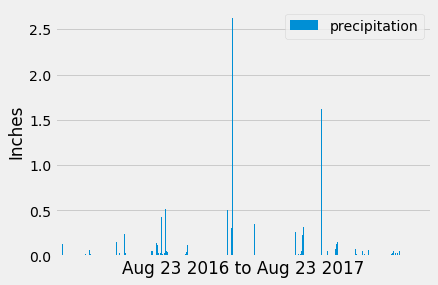

In [57]:
# Plot the 12 months of precipitaiton data
latestyr_date_prcp_df.set_index(['date'])
latestyr_date_prcp_df.plot.bar()
plt.xticks([])
plt.tight_layout()
plt.xlabel('Aug 23 2016 to Aug 23 2017')
plt.ylabel('Inches')
plt.show()

In [35]:
# Print the 12 month precipitation data summary statistics
latestyr_date_prcp_df.describe()

,precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


# Station Analysis

In [36]:
# Design a query to calculate the total number of stations.
locations = session.query(Measurement).group_by(Measurement.station).count()
print(locations)

9


In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Query to identify the station with the highest number of observations
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

('USC00519281', 2772)

In [39]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
sel = [Measurement.date, Measurement.tobs]

latest_year_tobs = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-08-23').\
    group_by(Measurement.date, Measurement.station).all()
latest_year_tobs

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [40]:
# Cast 12 month tobs data into a dictionary
# This is for rendering it into JSON format in Flask app
year_tobs = {date:prcp for date, prcp in latest_year_tobs}

In [41]:
tobs_df = pd.DataFrame(latest_year_tobs, columns=['date', 'tobs'])
tobs_df

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


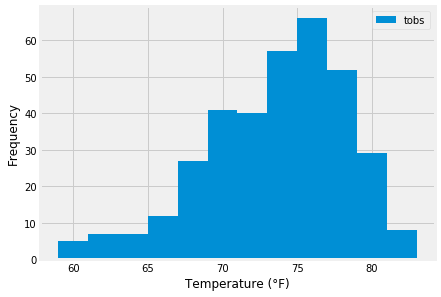

In [42]:
# Plot the temperatures onto a histogram
plt.hist(tobs_df['tobs'], bins = 12, label='tobs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

In [43]:
# Using the station id from the previous query, 
# calculate the lowest temperature recorded, 
# highest temperature recorded, 
# and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

top_tobs = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-08-23').\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
top_tobs

('USC00519281', 59.0, 83.0, 73.0968660968661)

## Code for Flask App (app.py)

In [123]:
# To return JSON list of stations
# First create list of station id and station name using a JOIN
station_list = session.query(Measurement.station, Station.name).filter(Measurement.station == Station.station).all()
station_list

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, H

In [67]:
# Cast this list into a dictionary
stn_dict = {station:name for station, name in station_list}
stn_dict

{'USC00519397': 'WAIKIKI 717.2, HI US',
 'USC00513117': 'KANEOHE 838.1, HI US',
 'USC00514830': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
 'USC00517948': 'PEARL CITY, HI US',
 'USC00518838': 'UPPER WAHIAWA 874.3, HI US',
 'USC00519523': 'WAIMANALO EXPERIMENTAL FARM, HI US',
 'USC00519281': 'WAIHEE 837.5, HI US',
 'USC00511918': 'HONOLULU OBSERVATORY 702.2, HI US',
 'USC00516128': 'MANOA LYON ARBO 785.2, HI US'}

In [58]:
# Using the station id from the previous query, 
# calculate the lowest temperature recorded, 
# highest temperature recorded, 
# and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

tobs_stats = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-08-23').\
    group_by(Measurement.tobs).\
    order_by(func.count(Measurement.station).desc())
tobs_stats

In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date=None, end_date=None):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    if end_date is None:
        end_date = session.query(func.max(Measurement.date))
        
    answer = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

    answer = list(np.ravel(answer))

    return answer

# function usage example
print(calc_temps('2012-02-28', '2012-03-01'))

[66.0, 71.23076923076923, 74.0]


In [62]:
engine.execute('SELECT name FROM Station WHERE station = "USC00519281"').fetchall()

[('WAIHEE 837.5, HI US',)]

# Conclusion

After my precipitation, temperature, and station analysis, it looks like I'll be headed to Waihee, HI sometime during August! Aloha for now!